# Foreground cleaning applied 21cm plus PSM foreground sims 
### In this notebook, we will perform a simple end-to-end simulation, beginning by generating a log-normal field, transforming to redshift-space, adding Planck Sky Model foregrounds and noise, then removing the foregrounds using serveral methods, and estimating the 1D and 2D power spectrum. 

In [1]:
import numpy as np
import numpy.fft as fft
import pylab as plt
import pyccl as ccl
plt.rcParams["figure.figsize"] = (14,7)

In [2]:
import fastbox
from fastbox.box import CosmoBox, default_cosmo
from fastbox.foregrounds import PlanckSkyModel
from fastbox.foregrounds import PointSourceModel
from nbodykit.lab import ArrayMesh
from nbodykit.algorithms.fftcorr import FFTCorr
from nbodykit.algorithms.fftpower import FFTPower
import time, sys

In [3]:
np.random.seed(12)

## Generate simulation box
### Generate a Gaussian random realisation with a non-linear power spectrum on a (1.25 Gpc)^3 grid with 150^3 cells at redshift z=0.3. Then, paint biased HI onto the density field, apply a log-normal transformation, add linear and non-linear velocities to transform to redshift space, and finally rescale by the brightness temperature.

In [4]:
t0 = time.time()
spread = 150

# (1a) Generate Gaussian box (1.25 Gpc on each side, spread^3 grid, z=0.3)
box = CosmoBox(cosmo=default_cosmo, box_scale=(1.25e3,1.25e3,1.25e3), nsamp=spread, 
               redshift=0.3, realise_now=False)
box.realise_density()

# (1b) Rescale tracer by bias [FIXME: Check this is being done in the right order]
tracer = fastbox.tracers.HITracer(box)
delta_hi = box.delta_x * tracer.bias_HI()

# (1c) Transform to a log-normal field
delta_ln = box.lognormal(delta_hi)

# (1d) Calculate radial velocity field (uses Gaussian density field; FIXME)
vel_k = box.realise_velocity(delta_x=box.delta_x, inplace=True)
vel_z = fft.ifftn(vel_k[2]).real # inverse FFT to get real-space radial velocity

# (1e) Transform to redshift space (also add non-linear velocity, sigma_nl=120 km/s)
delta_s = box.redshift_space_density(delta_x=delta_ln.real, velocity_z=vel_z, 
                                     sigma_nl=120., method='linear')

# (1f) Scale by mean brightness temperature (in mK), and include mean
signal_cube = tracer.signal_amplitude() * (1. + delta_s)

print("(1) Generating box complete (%3.3f sec)" % (time.time()-t0))

/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/pyccl/pk2d.py:198: RuntimeWarning: divide by zero encountered in log
  f, status = lib.pk2d_eval_multi(self.psp, np.log(k_use),
/Users/mirfan/Documents/FastBox/FastBox/fastbox/box.py:254: RuntimeWarning: invalid value encountered in true_divide
  Ax = 1.j * delta_k * self.Kx * (2.*np.pi/self.Lx) / k2
/Users/mirfan/Documents/FastBox/FastBox/fastbox/box.py:255: RuntimeWarning: invalid value encountered in true_divide
  Ay = 1.j * delta_k * self.Ky * (2.*np.pi/self.Ly) / k2
/Users/mirfan/Documents/FastBox/FastBox/fastbox/box.py:256: RuntimeWarning: invalid value encountered in true_divide
  Az = 1.j * delta_k * self.Kz * (2.*np.pi/self.Lz) / k2


(1) Generating box complete (4.360 sec)


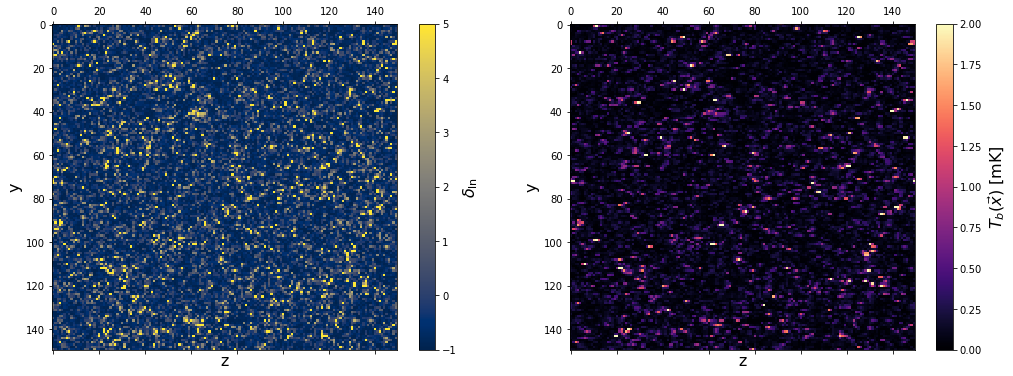

In [5]:
plt.subplot(121)
plt.matshow(delta_ln[10,:,:], vmin=-1., vmax=5., cmap='cividis', aspect='auto', fignum=False)
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$\delta_{\rm ln}$", fontsize=16)

plt.subplot(122)
plt.matshow(signal_cube[10,:,:], vmin=0., vmax=2., cmap='magma', aspect='auto', fignum=False)
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_b(\vec{x})$ [mK]", fontsize=16.)
plt.gcf().set_size_inches((17., 6.))

## Add foregrounds
### Use the Planck FFP10 simulations to create free-free and synchrotron maps and the Battye et al. 2012 model of point sources to create point source maps. 

Frequency range: 950.6 -- 1234.7 MHz



/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-pack

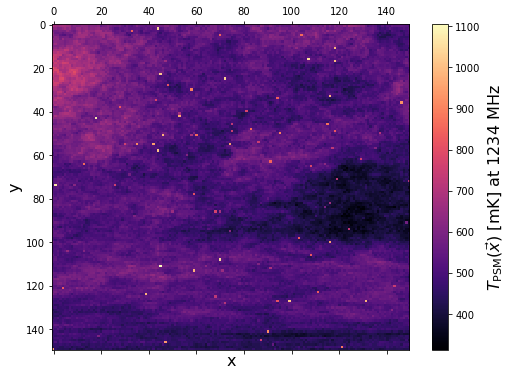

In [6]:
# Output frequency range
freqs = box.freq_array()

print("Frequency range: %3.1f -- %3.1f MHz\n" % (freqs[-1], freqs[0]))

# Angular pixels
ang_x, ang_y = box.pixel_array(redshift=box.redshift)
xside = len(ang_x)
yside = len(ang_y)

freeind = -2.1 # CHOOSE YOUR FREE-FREE SPECTRAL INDEX
lonv = 120. # Central point of box: Galctic longitude
latv = -59. # Central point of box: Galctic longitude
psmmodel = PlanckSkyModel(box)
diffuse_cube = psmmodel.construct_cube(redshift=None, rotation=(lonv, latv,0.), 
                       ref_freq=freqs[-1], free_idx=freeind, seed_syncidx=8)
    
#point sources
ps_ave_ind = -2.7 #CHOOSE YOUR PS PARAMETERS: average spectral index,
cut_off = 0.1 #cut-off flux in Jy and
ind_dev= 0.2 #index standard deviation
pointmod = PointSourceModel(box)
ps_cube, ps_means = pointmod.construct_cube(cut_off, ps_ave_ind, ind_dev, 
                       rotation=(lonv, latv, 0.), seed_clustering=7, seed_poisson=6)

fg_cube = diffuse_cube + ps_cube 

#let's have a look
plt.subplot(111)
plt.matshow(fg_cube[:,:,0], cmap='magma', aspect='auto', fignum=False)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm PSM}(\vec{x})$ [mK] at %d MHz" % (box.freq_array()[0]), fontsize=16.)
plt.gcf().set_size_inches((8., 6.))

## Add radiometer noise
### Adds a simple homogeneous white noise field for a MeerKAT-like multi-dish deep integration (64 dishes, 2 hours per pointing, assumed 1 degree FOV per pointing).

In [7]:
t0 = time.time()

# Generate homogeneous radiometer noise
noise_model = fastbox.noise.NoiseModel(box)
noise_cube = noise_model.realise_radiometer_noise(Tinst=18., tp=0.25, fov=1., Ndish=64)

print("(3) Adding noise complete (%3.3f sec)" % (time.time()-t0))

(3) Adding noise complete (0.104 sec)


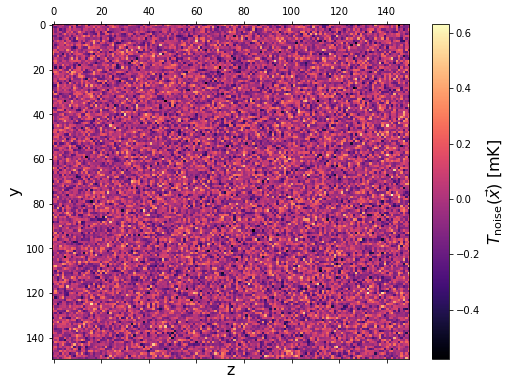

In [8]:
plt.matshow(noise_cube[-1,:,:], cmap='magma', aspect='auto')
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm noise}(\vec{x})$ [mK]", fontsize=16.)
plt.gcf().set_size_inches((8., 6.))

## Construct final data cube (convolve with beam and add noise)

In [9]:
# Construct MeerKAT L-band beam
mkbeam = fastbox.beams.KatBeamModel(box, model='L')

In [10]:
# Convolve with beam
obs_cube = mkbeam.convolve_real(signal_cube + fg_cube, pol='I')
smoo_signal_cube = mkbeam.convolve_fft(signal_cube, pol='I')

/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


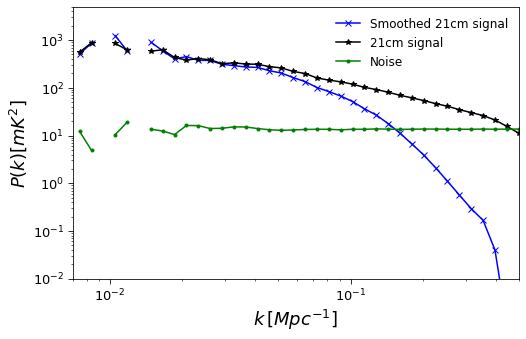

In [11]:
# Power spectra of noise and the signal; with and without the effect of the beam
sig_k, sig_pk, sig_stddev = box.binned_power_spectrum(delta_x=smoo_signal_cube, nbins=50)
nosmoosig_k, nosmoosig_pk, sig_stddev = box.binned_power_spectrum(delta_x=signal_cube, nbins=50)
noise_k, noise_pk, noise_stddev = box.binned_power_spectrum(delta_x=noise_cube, nbins=50)

fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
plt.axes(ax1)
plt.plot(sig_k, sig_pk, color='b', marker='x', ls='-',label="Smoothed 21cm signal")
plt.plot(sig_k, nosmoosig_pk, color='k', marker='*', ls='-',label="21cm signal")
plt.plot(sig_k, noise_pk, color='g', marker='.', ls='-',label="Noise")
plt.legend(loc='best', frameon=False, prop={'size':'large'})
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k \, [Mpc^{-1}]$", size=18)
plt.ylabel(r"$P(k) [mK^{2}]$", size=18)
plt.xlim((7e-3, 0.5))
plt.ylim((10e-3, 5000))
plt.gca().tick_params(axis='both', which='major', labelsize=13, length=5)
plt.show()

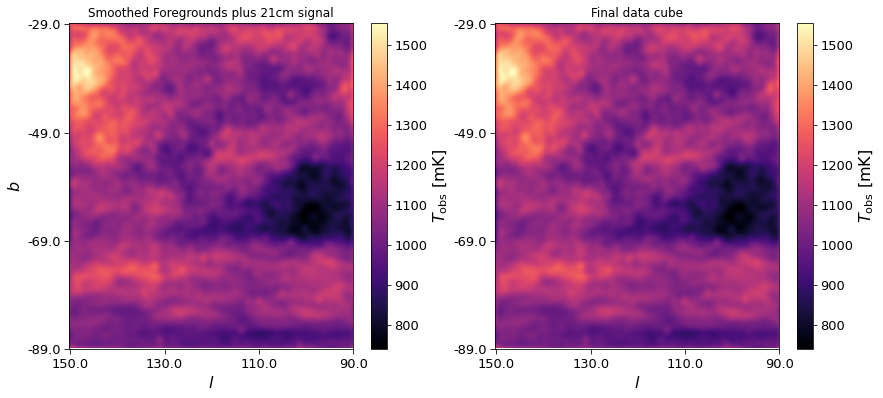

In [13]:
# Combine beam-convolve observation and noise
data_cube = obs_cube + noise_cube

# Plot after beam convolution
xspace = np.linspace(0, spread, 4)
xstart = ang_x[0] + lonv
ystart = ang_y[0] + latv
xbit = (ang_x[-1] - ang_x[0]) / spread
ybit = (ang_y[-1] - ang_y[0]) / spread

plt.subplot(121)
plt.imshow(obs_cube[:,:,-1], cmap='magma', aspect='auto')
plt.xlabel("$l$", fontsize=16)
plt.ylabel("$b$", fontsize=16)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=13) 
cbar.set_label(label=r"$T_{\rm obs}$ [mK]", fontsize=16.)
plt.gca().set_yticks(xspace)
plt.gca().set_yticklabels(np.flip(np.round(xspace*ybit + ystart, 1)))
plt.gca().set_xticks(xspace)
plt.gca().set_xticklabels(np.flip(np.round(xspace*xbit + xstart, 1)))
plt.gca().tick_params(axis='both', which='major', labelsize=13, length=5)
plt.title('Smoothed Foregrounds plus 21cm signal')
plt.subplot(122)
plt.imshow(data_cube[:,:,-1], cmap='magma', aspect='auto')
plt.xlabel("$l$", fontsize=16)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=13) 
cbar.set_label(label=r"$T_{\rm obs}$ [mK]", fontsize=16.)
plt.gca().set_yticks(xspace)
plt.gca().set_yticklabels(np.flip(np.round(xspace*ybit + ystart, 1)))
plt.gca().set_xticks(xspace)
plt.gca().set_xticklabels(np.flip(np.round(xspace*xbit + xstart, 1)))
plt.gca().tick_params(axis='both', which='major', labelsize=13, length=5)
plt.gcf().set_size_inches((14., 6.))
plt.title('Final data cube')
plt.show()

## Try several FG cleaning methods

In [14]:
#KPCA
n = 5
gnum = 1./(10.*n)
#use pca with only 2 mode then try kernal pca
pre_cleaned_cube, U_fg_pc, amp_fg_pc = fastbox.filters.pca_filter(data_cube, 
                                                         nmodes=2, 
                                                         return_filter=True)


cleaned_cubePCK, kpca_transformPCK = fastbox.filters.kernel_pca_filter(pre_cleaned_cube, 
                                                                              nmodes=n, 
                                                                              gamma=gnum, ## FIXME
                                                                              coef0 = 0.9, #default=1
                                                                              return_filter=True, 
                                                                              kernel='sigmoid')

In [15]:
#PCA
nelse = 3
cleaned_cubePCA, U_fg_pca, amp_fg_pca = fastbox.filters.pca_filter(data_cube, 
                                                         nmodes=nelse, 
                                                         return_filter=True)

cleaned_cubePCA_PC, U_fg_pca_pc, amp_fg_pca_pc = fastbox.filters.pca_filter(pre_cleaned_cube, 
                                                         nmodes=nelse, 
                                                         return_filter=True)

## Calculate 1D PS of foreground cleaned maps

In [18]:
sig_k, sig_pk, _ = box.binned_power_spectrum(delta_x=smoo_signal_cube, nbins=50)

#PCA on the data cube
proc_k0, proc_pk0, _ = box.binned_power_spectrum(delta_x=cleaned_cubePCA, nbins=50)

#PCA on the pre-cleaned  cube
proc_k, proc_pk, _ = box.binned_power_spectrum(delta_x=cleaned_cubePCA_PC, nbins=50)

#KPCA on pre-cleaned cube
kandp_k, kandp_pk, _ = box.binned_power_spectrum(delta_x=cleaned_cubePCK, nbins=50)

/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.015 0.0575 0.1


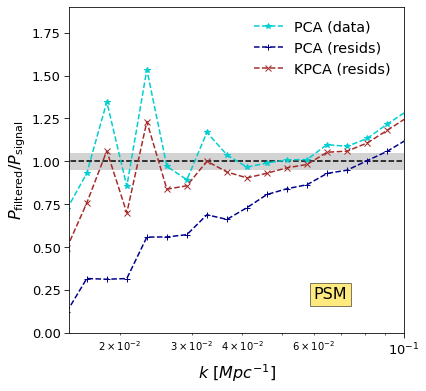

In [19]:
# Plot Pk/true P(k), so the goal is to reach 1
xminv = 1.5e-2
xmaxv = 1.e-1
xmidv = ((xmaxv - xminv)/2.) + xminv
print(xminv, xmidv, xmaxv)

plt.subplot(111)
plt.plot(proc_k0, (proc_k0*0.) + 1.0, color='black', ls='dashed')
plt.fill_between(proc_k0, (proc_k0*0.) +0.95,  (proc_k0*0.) + 1.05, facecolor='lightgray')
plt.errorbar(proc_k0, (proc_pk0)/ sig_pk, color='darkturquoise', marker='*', ls='dashed',label="PCA (data)")
plt.errorbar(proc_k, (proc_pk/ sig_pk), color='darkblue', marker='+', ls='dashed', label="PCA (resids)")
plt.errorbar(kandp_k, (kandp_pk)/ sig_pk, color='brown', marker='x', ls='dashed', label="KPCA (resids)")
plt.gca().tick_params(axis='both', which='major', labelsize=13, length=5)
plt.legend(loc='upper right', ncol=1, frameon=False, prop={'size':'x-large'})
plt.xlim((xminv, xmaxv))
plt.xscale('log')
plt.ylim((0.0, 1.9))
plt.xlabel(r"$k \, \,  [Mpc^{-1}]$", size=16)
plt.ylabel(r"$P_{\rm{filtered}} / P_{\rm{signal}}$", size=16)
plt.gcf().set_size_inches((6., 6.))
plt.text(0.06, 0.20, 'PSM', fontsize=16, bbox=dict(facecolor='gold', alpha=0.5))
plt.show()

## Calculate cylndrically averaged PS

/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


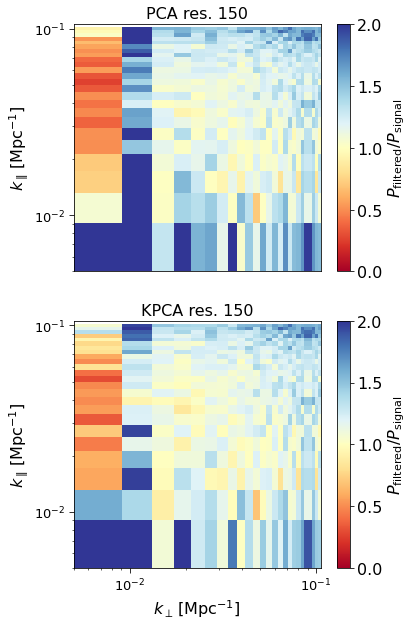

In [20]:
pk2d_sig, _, _ = box.cylindrically_ave_power_spectrum(smoo_signal_cube, 25, 0.005, 0.11)
pk2d_pca, _, _ = box.cylindrically_ave_power_spectrum(cleaned_cubePCA, 25, 0.005, 0.11)
pk2d_kpca, kperp, kpara = box.cylindrically_ave_power_spectrum(cleaned_cubePCK, 25, 0.005, 0.11)

plt.subplot(211)
plt.imshow(pk2d_pca / pk2d_sig, extent=[np.amin(kperp),np.amax(kperp), np.amin(kpara),np.amax(kpara)], \
               vmin=0., vmax=2.,cmap='RdYlBu')
plt.gca().tick_params(axis='both', which='major', labelsize=13, length=5)
plt.gca().tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xticks([])
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$k_\parallel \, [ {\rm Mpc}^{-1}]$',fontsize=16)
cbar = plt.colorbar(fraction=0.1)
cbar.set_label(label=r"$P_{\rm{filtered}} / P_{\rm{signal}}$", size=16)
cbar.ax.tick_params(labelsize=16)
plt.title('PCA res. 150', fontsize=16)
plt.subplot(212)
plt.imshow(pk2d_kpca / pk2d_sig, extent=[np.amin(kperp),np.amax(kperp), np.amin(kpara),np.amax(kpara)], \
               vmin=0., vmax=2.0,cmap='RdYlBu')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$k_\parallel \, [ {\rm Mpc}^{-1}]$',fontsize=16)
plt.xlabel(r'$k_\perp \, [ {\rm Mpc}^{-1}]$',fontsize=16)
plt.gca().tick_params(axis='both', which='major', labelsize=13, length=5)
cbar = plt.colorbar(fraction=0.1)
cbar.set_label(label=r"$P_{\rm{filtered}} / P_{\rm{signal}}$", size=16)
cbar.ax.tick_params(labelsize=16)
plt.gcf().set_size_inches((6., 10.))
plt.title('KPCA res. 150', fontsize=16)
plt.show()

## Cross correlations

In [21]:
from fastbox.box import CosmoBox, default_cosmo
from fastbox.halos import HaloDistribution
from nbodykit.lab import ArrayMesh, ArrayCatalog
from nbodykit.algorithms.fftcorr import FFTCorr
from nbodykit.algorithms.fftpower import FFTPower

In [22]:
#Create halo distribution
#νobs = νem/(1 + z) --> 1+z = vem/vobs 
zed = (1420./freqs) - 1
bz = np.sqrt(1 + zed) 
halos = HaloDistribution(box, mass_range=(1e12, 1e15), mass_bins=10)
Nhalos = halos.halo_count_field(box.delta_x, nbar=2e-3, bias=bz)
halo_cat = halos.realise_halo_catalogue(Nhalos, scatter=False, scatter_type='uniform')

In [23]:
# Project catalogue onto mesh
array_cat = ArrayCatalog({'Position': halo_cat})
mesh_cat = array_cat.to_mesh(Nmesh=box.N, BoxSize=(box.Lx, box.Ly, box.Lz),
                             window='tsc', compensated=True)

/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  after removing the cwd from sys.path.


In [24]:
#project cleaned data cubes onto mesh
md_kpca = ArrayMesh(cleaned_cubePCK, BoxSize=(box.Lx, box.Ly, box.Lz))
md_pca = ArrayMesh(cleaned_cubePCA, BoxSize=(box.Lx, box.Ly, box.Lz))
md_signal = ArrayMesh(smoo_signal_cube, BoxSize=(box.Lx, box.Ly, box.Lz))

# Calculate cross- and auto-power spectra
pspecAutoH1 = FFTPower(first=md_signal, mode='1d', los=[0, 0, 1], Nmu=5)
pspecAutoH1.run()
pspecAutoCat = FFTPower(first=mesh_cat, mode='1d', los=[0, 0, 1], Nmu=5)
pspecAutoCat.run()
pspecCC = FFTPower(first=mesh_cat, mode='1d', second=md_signal, los=[0, 0, 1], Nmu=5)
pspecCC.run()
pspecKPCA = FFTPower(first=md_kpca, mode='1d', second=mesh_cat, los=[0, 0, 1], Nmu=5)
pspecKPCA.run()
pspecKPCAself = FFTPower(first=md_kpca, mode='1d', second=None, los=[0, 0, 1], Nmu=5)
pspecKPCAself.run()
pspecPCA = FFTPower(first=md_pca, mode='1d', second=mesh_cat, los=[0, 0, 1], Nmu=5)
pspecPCA.run()
pspecPCAself = FFTPower(first=md_pca, mode='1d', second=None, los=[0, 0, 1], Nmu=5)
pspecPCAself.run()

(<BinnedStatistic: dims: (k: 75), variables: ('k', 'power', 'modes')>, None)

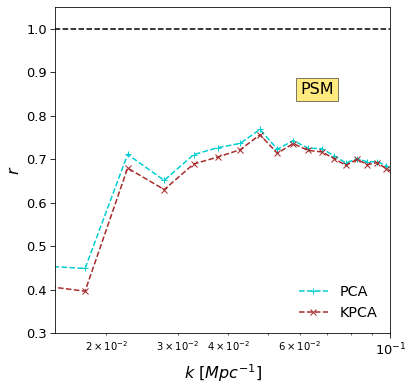

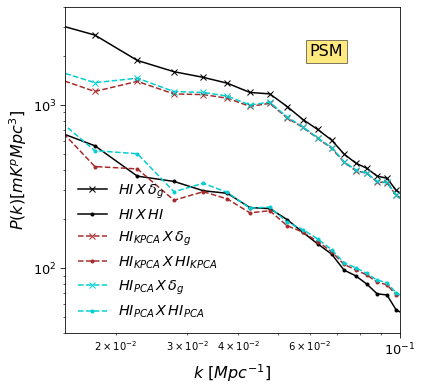

In [27]:
# r^2 = P_x^2 / (P_A P_B) 
r_pca = pspecPCA.power['power'].real / np.sqrt(pspecAutoH1.power['power'].real * pspecAutoCat.power['power'].real )
r_kpca = pspecKPCA.power['power'].real / np.sqrt(pspecAutoH1.power['power'].real * pspecAutoCat.power['power'].real )

plt.subplot(111)
plt.plot(proc_k0, (proc_k0*0.) + 1.0, color='black', ls='dashed')
plt.plot(pspecAutoH1.power['k'], r_pca, '+', color='darkturquoise', ls='dashed', label="PCA")
plt.plot(pspecAutoH1.power['k'], r_kpca, 'x', color='brown', ls='dashed', label="KPCA")
plt.xlim((xminv, xmaxv))
plt.ylim((1e-1, 1.05))
plt.xlim((xminv, xmaxv))
plt.xscale('log')
plt.gca().tick_params(axis='both', which='major', labelsize=13, length=5)
plt.legend(loc='lower right', ncol=1, frameon=False, prop={'size':'x-large'})
plt.xlabel(r"$k \, \,  [Mpc^{-1}]$", size=16)
plt.ylabel(r"$r$", size=16)
plt.ylim([0.3, 1.05])
plt.gcf().set_size_inches((6., 6.))
plt.text(0.06, 0.85, 'PSM', fontsize=16, bbox=dict(facecolor='gold', alpha=0.5))
plt.show()

# Plot power spectra
plt.subplot(111)
plt.plot(pspecCC.power['k'], pspecCC.power['power'].real, 'kx', 
         ls='solid', label="$HI \, X \, \delta_{g}$")
plt.plot(pspecAutoH1.power['k'], pspecAutoH1.power['power'].real, 'k.',
         ls='solid', label="$HI \, X \, HI$")
plt.plot(pspecKPCA.power['k'], pspecKPCA.power['power'].real, 'x', color='brown', 
         ls='dashed', label="$HI_{KPCA}\, X \, \delta_{g}$")
plt.plot(pspecKPCAself.power['k'], pspecKPCAself.power['power'].real, '.', color='brown', 
         ls='dashed', label="$HI_{KPCA} \, X \, HI_{KPCA}$")
plt.plot(pspecPCA.power['k'], pspecPCA.power['power'].real, 'x', color='darkturquoise', 
         ls='dashed', label="$HI_{PCA} \, X \, \delta_{g}$")
plt.plot(pspecPCAself.power['k'], pspecPCAself.power['power'].real, '.', color='darkturquoise', 
         ls='dashed', label="$HI_{PCA} \, X \,HI_{PCA}$")
plt.yscale('log')
plt.ylim((4e1, 4e3))
plt.xlim((xminv, xmaxv))
plt.xscale('log')
plt.xlabel(r"$k \, \,  [Mpc^{-1}]$", size=16)
plt.ylabel(r"$P(k) [mK^{p}Mpc^{3}]$", size=16)
plt.gca().tick_params(axis='both', which='major', labelsize=13, length=5)
plt.legend(loc='lower left', ncol=1, frameon=False, prop={'size':'x-large'})
plt.gcf().set_size_inches((6., 6.))
plt.text(0.06, 2000, 'PSM', fontsize=16, bbox=dict(facecolor='gold', alpha=0.5))
plt.show()